# Исследование объявлений о продаже квартир

**Задача:**
Обозначить параметры для определения рыночной стоимость объектов недвижимости в Санкт-Петербурге и Ленобласти. 


### План работы над проектом
1. [Импорт данных](#step1); 
2. [Предобработка данных](#step2);
3. [Добавление данных в таблицу](#step3);
4. [Исследовательский анализ данных](#step4);
5. [Общий вывод](#step5).

<div id='step1'/>

### Шаг 1. Импорт данных и ознакомление 

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('real_estate_data.csv', sep='\t')

In [3]:
# Напишем функцию для ознакомления с данными:
def standart_opening(data):
    data.info()
    print('--------------------------------------')
    print('Дубликаты:')
    print (data.duplicated().sum(), 'дубликатов')
    print('--------------------------------------')
    print('Пропуски:')
    print (data.isna().mean())
    print('--------------------------------------')
    print('Начало таблицы')
    print (data.head())
    print('--------------------------------------')
    print('Конец таблицы')
    print (data.tail())

standart_opening(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

В первом приближении видно, что есть много пропусков. Также будет нужно привести в соответствие некоторые типы данных. 

<div id='step2'/>

### Шаг 2. Предобработка данных

Начнем с пропусков:

In [4]:
df.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Часть пропусков можно будет заменить на средние значения, например, высоту потолков. Незначительное количество пропусков - удалить. Часть незаполенных данных оставить без изменений, если они не влияют на результаты исследования. 

В первую очередь я удалила строки, в которых не указано местоположение квартиры в столбце `'locality_name'`. Их слишком мало, чтобы с ними возиться. Затем я решила удалить все строки с пропусками по столбцу `'floors_total'`, потому что а)отсутствующих данных немного, б)эти данные влияют только на расчет средней высоты потолка.

In [5]:
df.dropna(subset = ['locality_name'],inplace = True)
df['locality_name'].isnull().sum()

0

In [6]:
df.dropna(subset = ['floors_total'],inplace = True)
df['floors_total'].isnull().sum()

0

In [7]:
# напишем функцию для замены пропущенных значений для высоты потолков:
def fill_c_height(floors_total_name):
    median = df[df['floors_total'] == floors_total_name]['ceiling_height'].median()
    df.loc[(df['ceiling_height'].isnull()) & (df['floors_total'] == floors_total_name), 'ceiling_height'] = median
    
for floors_total_name in df['floors_total'].unique(): 
    fill_c_height(floors_total_name)
    
df[df['ceiling_height'].isnull()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
11575,9,9900000.0,101.0,2016-04-28T00:00:00,3,NaN,33.0,53.0,32,False,...,21.0,0.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,53.0


In [8]:
df.dropna(subset = ['ceiling_height'],inplace = True)
df['ceiling_height'].isnull().sum()

0

Этажность дома влияет на высоту потолков. Поэтому пропущенные значения я заменила медианой из данных по домам аналогичной этажности. В итоге остался один уникальный объект в 33-х этажном доме, по которму нельзя подобрать медианное значение высоты потолка. Я его удалила. 

In [9]:
df['is_apartment'] = df['is_apartment'].astype('bool')
df['is_apartment'].isnull().sum()

0

В столбце `'is_apartment'` был неправильно указан тип данных `object`. Объект или является аппартаментами или нет. Я изменила тип данных на `bool` и пропуски исчезли. 

In [10]:
df['balcony'] = df['balcony'].fillna(0)
df['balcony'].isnull().sum()

0

Пропуски в столбце с балконами, скорее всего, говорят об их отсутствии. Поэтому я их заменила на О.

In [11]:
df.query('locality_name == "Санкт-Петербург"')['airports_nearest'].isnull().sum()

84

In [12]:
# найдем медианное значение расстояния до аэропорта и заполним им пропуски:
spb_airport_median = df[df['locality_name'] == 'Санкт-Петербург']['airports_nearest'].median()
df.loc[(df['locality_name'] == 'Санкт-Петербург') & (df['airports_nearest'].isna()), 'airports_nearest'] = spb_airport_median
df.query('locality_name == "Санкт-Петербург"')['airports_nearest'].isnull().sum()

0

In [13]:
df.query('locality_name == "Санкт-Петербург"')['cityCenters_nearest'].isnull().sum()

60

In [14]:
# найдем медианное значение расстояния до центра СПб и заполним им пропуски:
spb_center_median = df[df['locality_name'] == 'Санкт-Петербург']['cityCenters_nearest'].median()
df.loc[(df['locality_name'] == 'Санкт-Петербург') & 
       (df['cityCenters_nearest'].isna()), 'cityCenters_nearest'] = spb_center_median
df.query('locality_name == "Санкт-Петербург"')['cityCenters_nearest'].isnull().sum()

0

Я обработала пропуски в столбцах `'cityCenters_nearest'` и `'airports_nearest'` по Санкт-Петербургу, потому что это нужно для проведения дальнейшего анализа. 

Посмотрим на оставшиеся пропуски:

In [15]:
df.query('locality_name == "Санкт-Петербург"'
        )[['parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest']].isnull().sum()

parks_around3000      60
parks_nearest       8399
ponds_around3000      60
ponds_nearest       7715
dtype: int64

In [16]:
df.query('locality_name != "Санкт-Петербург"'
        )[['airports_nearest', 'cityCenters_nearest','parks_around3000', 
           'parks_nearest', 'ponds_around3000', 'ponds_nearest']].isnull().sum()

airports_nearest       5440
cityCenters_nearest    5441
parks_around3000       5440
parks_nearest          7135
ponds_around3000       5440
ponds_nearest          6814
dtype: int64

Для других населенных пукнтов медианные значения до центра могут отличаться и изучение этих данных не является целью проекта, поэтому для них я оставила пропуски как есть.
Разработчикам следует обратить внимание на работу алгоритма, присваивающего данные о расположени объекта. Процент отсутствующих значений довольно высокий.

In [17]:
# заменим тип данных
df['last_price'] = df['last_price'].astype('int')
df.dtypes

total_images              int64
last_price                int32
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
is_apartment               bool
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
cityCenters_nearest     float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
dtype: object

Обработаем пропуски в столбцах `'living_area'` и `'kitchen_area'`:

In [18]:
df['living_area'].isna().sum()  

1865

In [19]:
for rooms_name in df['rooms'].unique():
    rooms_name_mean = df[df['rooms'] == rooms_name]['living_area'].mean()
    df.loc[(df['rooms'] == rooms_name) & (df['living_area'].isna()), 'living_area'] = rooms_name_mean 
df['living_area'].isna().sum()

0

In [20]:
df['kitchen_area'].isna().sum()  

2222

In [21]:
for rooms_name in df['rooms'].unique():
    rooms_name_kitchen_mean = df[df['rooms'] == rooms_name]['kitchen_area'].mean()
    df.loc[(df['rooms'] == rooms_name) & (df['kitchen_area'].isna()), 'kitchen_area'] = rooms_name_kitchen_mean 
df['kitchen_area'].isna().sum()

194

In [22]:
# оставшиеся пропуски заполним разницой между total_area и living_area:
for rooms_name in df['rooms'].unique():
    rooms_name_kitchen_diff = df[df['rooms'] == rooms_name]['total_area'
                                                           ].mean() - df[df['rooms'] == rooms_name]['living_area'].mean()
    df.loc[(df['rooms'] == rooms_name) & (df['kitchen_area'].isna()), 'kitchen_area'] = rooms_name_kitchen_diff 
df['kitchen_area'].isna().sum()

0

Пропущенные значения я заполнила средними данными по площади в квартирах с таким же количеством комнат. 

In [23]:
df.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5440
cityCenters_nearest      5441
parks_around3000         5500
parks_nearest           15534
ponds_around3000         5500
ponds_nearest           14529
days_exposition          3171
dtype: int64

Оставшиеся пропущенные значения я решила оставить без изменений. 

<div id='step3'/>

### Шаг 3. Добавление данных в таблицу

- Цена за квадрантый метр:

In [24]:
df['sq_m_price'] = df['last_price'] / df['total_area']
df.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_m_price
0,20,13000000,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.000000,8,True,...,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.370370
1,7,3350000,40.4,2018-12-04T00:00:00,1,2.75,11.0,18.600000,1,True,...,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.792079
2,10,5196000,56.0,2015-08-20T00:00:00,2,2.55,5.0,34.300000,4,True,...,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286
3,0,64900000,159.0,2015-07-24T00:00:00,3,2.60,14.0,47.373054,9,True,...,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.100629
4,2,10000000,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.000000,13,True,...,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.000000


- День, месяц, год для `'first_day_exposition'`:

In [25]:
df['first_day_exposition'] = (
    pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
    + pd.Timedelta(hours=3))

df['weekday_exp'] = df['first_day_exposition'].dt.weekday
df['month_exp'] = df['first_day_exposition'].dt.month
df['year_exp'] = df['first_day_exposition'].dt.year
df.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_m_price,weekday_exp,month_exp,year_exp
0,20,13000000,108.0,2019-03-07 03:00:00,3,2.70,16.0,51.000000,8,True,...,16028.0,1.0,482.0,2.0,755.0,NaN,120370.370370,3,3,2019
1,7,3350000,40.4,2018-12-04 03:00:00,1,2.75,11.0,18.600000,1,True,...,18603.0,0.0,NaN,0.0,NaN,81.0,82920.792079,1,12,2018
2,10,5196000,56.0,2015-08-20 03:00:00,2,2.55,5.0,34.300000,4,True,...,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286,3,8,2015
3,0,64900000,159.0,2015-07-24 03:00:00,3,2.60,14.0,47.373054,9,True,...,6800.0,2.0,84.0,3.0,234.0,424.0,408176.100629,4,7,2015
4,2,10000000,100.0,2018-06-19 03:00:00,2,3.03,14.0,32.000000,13,True,...,8098.0,2.0,112.0,1.0,48.0,121.0,100000.000000,1,6,2018


- Условное обозначения для этажа (первый, последний, другой):

In [26]:
def floor_name(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floors_total'] == row['floor']:
        return 'последний'
    else:
        return 'другой'
df['floor_name'] = df.apply(floor_name, axis=1)
df.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_m_price,weekday_exp,month_exp,year_exp,floor_name
0,20,13000000,108.0,2019-03-07 03:00:00,3,2.70,16.0,51.000000,8,True,...,1.0,482.0,2.0,755.0,NaN,120370.370370,3,3,2019,другой
1,7,3350000,40.4,2018-12-04 03:00:00,1,2.75,11.0,18.600000,1,True,...,0.0,NaN,0.0,NaN,81.0,82920.792079,1,12,2018,первый
2,10,5196000,56.0,2015-08-20 03:00:00,2,2.55,5.0,34.300000,4,True,...,1.0,90.0,2.0,574.0,558.0,92785.714286,3,8,2015,другой
3,0,64900000,159.0,2015-07-24 03:00:00,3,2.60,14.0,47.373054,9,True,...,2.0,84.0,3.0,234.0,424.0,408176.100629,4,7,2015,другой
4,2,10000000,100.0,2018-06-19 03:00:00,2,3.03,14.0,32.000000,13,True,...,2.0,112.0,1.0,48.0,121.0,100000.000000,1,6,2018,другой


- Относительное значения жилой площади и площади кухни:

In [27]:
df['living_part'] = df['living_area'] / df['total_area']
df['kitchen_part'] = df['kitchen_area'] / df['total_area']
df.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,sq_m_price,weekday_exp,month_exp,year_exp,floor_name,living_part,kitchen_part
0,20,13000000,108.0,2019-03-07 03:00:00,3,2.70,16.0,51.000000,8,True,...,2.0,755.0,NaN,120370.370370,3,3,2019,другой,0.472222,0.231481
1,7,3350000,40.4,2018-12-04 03:00:00,1,2.75,11.0,18.600000,1,True,...,0.0,NaN,81.0,82920.792079,1,12,2018,первый,0.460396,0.272277
2,10,5196000,56.0,2015-08-20 03:00:00,2,2.55,5.0,34.300000,4,True,...,2.0,574.0,558.0,92785.714286,3,8,2015,другой,0.612500,0.148214
3,0,64900000,159.0,2015-07-24 03:00:00,3,2.60,14.0,47.373054,9,True,...,3.0,234.0,424.0,408176.100629,4,7,2015,другой,0.297944,0.071013
4,2,10000000,100.0,2018-06-19 03:00:00,2,3.03,14.0,32.000000,13,True,...,1.0,48.0,121.0,100000.000000,1,6,2018,другой,0.320000,0.410000


<div id='step4'/>

### Шаг 4. Исследовательский анализ данных:

### *Площадь, цена, число комнат, высота потолков:*

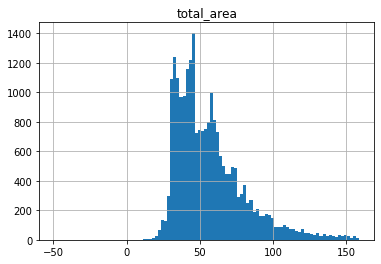

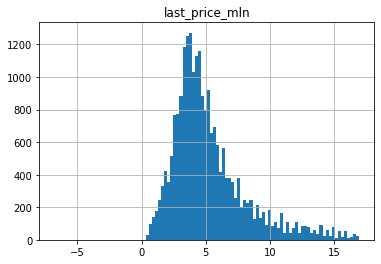

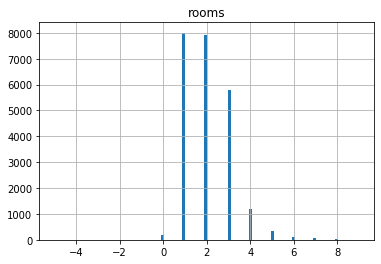

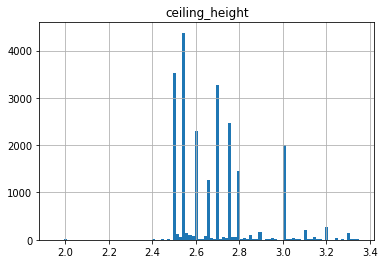

In [28]:
# построим гистограммы для каждого параметра:
df['last_price_mln'] = df['last_price'] / 1000000
hist_data = df[['total_area', 'last_price_mln', 'rooms', 'ceiling_height']]

for row in hist_data:
    Q1 = hist_data[row].describe()['25%']
    Q3 = hist_data[row].describe()['75%'] 
    hist_data[row].hist(bins=100, range=(Q1-3*(Q3-Q1), Q3+3*(Q3-Q1)))
    plt.title(row)
    plt.show();

In [29]:
hist_data.describe()

,total_area,last_price_mln,rooms,ceiling_height
count,23564.000000,23564.000000,23564.000000,23564.000000
mean,60.321098,6.539916,2.070616,2.735741
std,35.656831,10.911144,1.078596,0.997020
min,12.000000,0.012190,0.000000,1.000000
25%,40.000000,3.400000,1.000000,2.550000
50%,52.000000,4.646000,2.000000,2.650000
75%,69.700000,6.790000,3.000000,2.750000
max,900.000000,763.000000,19.000000,100.000000


В столбце с общей площадью нашлись неправдоподобно низкие и высокие значения. 
На графике видно, что основная масса объявлений начинается с 25м2 и есть пики на значениях ок 30, 45, 60 м2. Я связываю это с наличем в базе большого количества квартир с типовой планировкой и одинаковой площадью. 
Среднее и медианное значения отличаются за счет сверхвысоких значений. Распределение данных похоже на нормальное, с хвостом возрастающих значений.

В столбце с ценой также есть очень низкие и высокие значения. Надо будет проверить, как коррелируют эти данные с общей площадью,  количеством комнат и ценой за кв.м. Среднее и медианное значения сильно отличаются (среднее близко к Q3), предположительно, за счет хвоста высоких значений. Судя по графику, основная часть объектов продается по цене в диапазоне 3-5 млн. Интересно, что выше значения в 5млн периодически появляются отдельные пики. Я связываю это с тем, что продавцы оценивают свою недвижимость относительно цен в рынке и поэтому объекты в схожих категориях дают такой пик. 

График по количеству комнат выглядит реалистично. Есть небольшой хвост высоких значений, среднее и медианное близки.  Большинство квартир 1-2-3 комнатные. Смущает только 0 комнат - что это, неправильно указанные значения при вводе данных? Надо проверить. 

В столбце с высотой потолка есть нереалистичные минимальные и максимальные значения. Это выброс или ошибка ввода. Седнее и медианное значения отличаются не слишком сильно. Однако, то что среднее близко к Q3 подтверждает влияние на данные высоких значений. У подавляющего большинства объектов высота потолка всего 2.55м. 

In [30]:
hist_data.corr()

,total_area,last_price_mln,rooms,ceiling_height
total_area,1.000000,0.653626,0.758726,0.087115
last_price_mln,0.653626,1.000000,0.363186,0.069136
rooms,0.758726,0.363186,1.000000,0.047557
ceiling_height,0.087115,0.069136,0.047557,1.000000


Матрица корреляции показывает, что цена в `'last_price'` закономерно сильно коррелирует с общей площадью, но значительно меньше зависит от количества комнат. Хотя количество комнат коррелирует с площадью. Высота потолка почти совершенно не влияет на стоимость. Итересно, что чем больше площадь, тем больше высота потолка.   

### *Время продажи квартиры:*

In [31]:
df.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,sq_m_price,weekday_exp,month_exp,year_exp,floor_name,living_part,kitchen_part,last_price_mln
0,20,13000000,108.0,2019-03-07 03:00:00,3,2.70,16.0,51.000000,8,True,...,755.0,NaN,120370.370370,3,3,2019,другой,0.472222,0.231481,13.000
1,7,3350000,40.4,2018-12-04 03:00:00,1,2.75,11.0,18.600000,1,True,...,NaN,81.0,82920.792079,1,12,2018,первый,0.460396,0.272277,3.350
2,10,5196000,56.0,2015-08-20 03:00:00,2,2.55,5.0,34.300000,4,True,...,574.0,558.0,92785.714286,3,8,2015,другой,0.612500,0.148214,5.196
3,0,64900000,159.0,2015-07-24 03:00:00,3,2.60,14.0,47.373054,9,True,...,234.0,424.0,408176.100629,4,7,2015,другой,0.297944,0.071013,64.900
4,2,10000000,100.0,2018-06-19 03:00:00,2,3.03,14.0,32.000000,13,True,...,48.0,121.0,100000.000000,1,6,2018,другой,0.320000,0.410000,10.000


count    20393.000000
mean       180.747659
std        219.736349
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

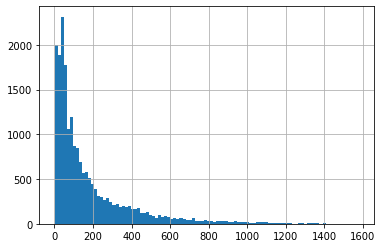

In [32]:
df['days_exposition'].hist(bins=100);
df['days_exposition'].describe()

Гистограмма показывает большой разброс значений от 1 до 1580 дней, со всплеском в районе 50. Медиана и среднее время экспозиции объявлений отличаются почти вдвое. 6 мес против 3. Очевидно, что на среднее влияет длинный хвост. 

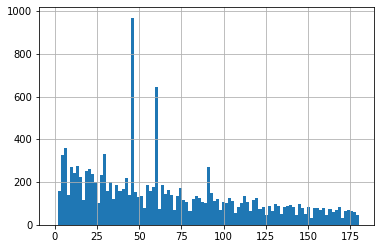

In [33]:
df['days_exposition'].hist(bins=100, range=(0, 180));

Я сузила диапазон отображаемых значений до 180 (6 мес). Здесь еще ярче видны пики в районе 45-60 дней экспозиции объявления. Посмотрим график: 

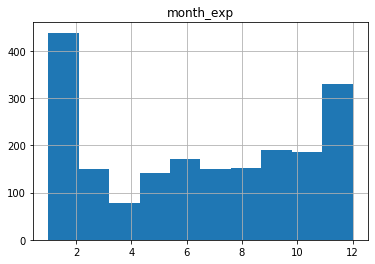

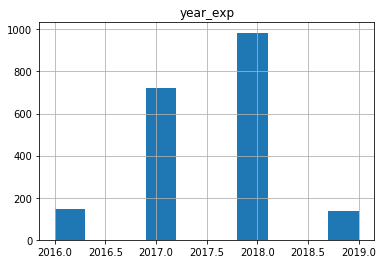

In [34]:
exp_missing = df.query('45 < days_exposition < 60')
hist_exp_missing = exp_missing[['month_exp', 'year_exp']]

for row in hist_exp_missing:
    hist_exp_missing[row].hist()
    plt.title(row)
    plt.show();

Анализ данных выявил интересную закономерность. Большинство объявлений, удалявшихся за 45-60 дней, было закрыто в дек-янв 2017/2018 г. Видимо, именно благодаря им 2017-2018 год бьет рекорды по сделкам с недвижимостью. Но более вероятна гипотеза о системном сбое, приведшем к удалению большого количества данных.  

На 180-то дневном графике видно, что первые пики приходятся на 7 дней, потом на месяц. Мне непонятны резкие всплески значений в диапазоне 45-60, возможно, они влияют на общую картину. Пока можно сделать вывод, что в основном объявления не висят больше года. Быстрая продажа происходит в течение первого месяца, меньше одной недели - очень быстро. Среднее по медиане - 3 месяца, среднее с учетом висяков - полгода. 

### *Выбросы:*

Исследуя данные по площади я заметила неправдоподобные низкие и очень высокие значения. Надо проверить, в чем тут дело. 

In [35]:
df['total_area'].describe()

count    23564.000000
mean        60.321098
std         35.656831
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

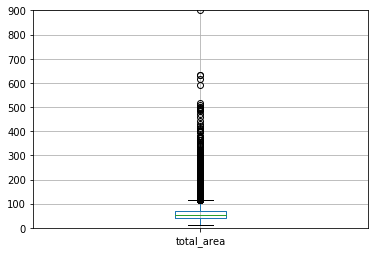

In [36]:
plt.ylim(0, 900)
df.boxplot('total_area')

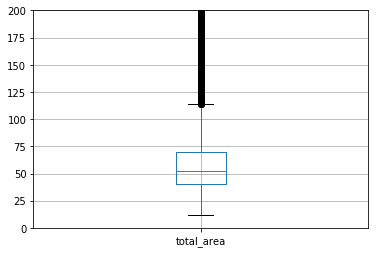

In [37]:
plt.ylim(0, 200)
df.boxplot('total_area')

Площадь квартиры меньше 25 м2 выглядит нереалистично. Необходимо выяснить, сколько таких объявлений, если значение статистически незначимо - удалить. 

In [38]:
df.query('total_area < 25').sort_values(
    by = 'total_area', ascending=False).head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,sq_m_price,weekday_exp,month_exp,year_exp,floor_name,living_part,kitchen_part,last_price_mln
13471,15,3350000,24.9,2018-03-21 03:00:00,0,2.50,16.0,14.1,6,True,...,711.0,61.0,134538.152610,2,3,2018,другой,0.566265,0.419938,3.35
18190,3,3320000,24.9,2018-03-06 03:00:00,1,2.80,21.0,17.4,17,True,...,653.0,198.0,133333.333333,1,3,2018,другой,0.698795,0.383296,3.32
23579,7,2350000,24.8,2018-06-07 03:00:00,1,2.60,10.0,18.0,2,True,...,NaN,89.0,94758.064516,3,6,2018,другой,0.725806,0.384842,2.35
9579,9,3450000,24.8,2019-02-01 03:00:00,0,2.68,35.0,16.0,17,True,...,80.0,45.0,139112.903226,4,2,2019,другой,0.645161,0.421631,3.45
20757,3,2210000,24.8,2017-10-26 03:00:00,1,2.65,24.0,16.7,5,True,...,136.0,329.0,89112.903226,3,10,2017,другой,0.673387,0.384842,2.21


In [39]:
df = df.query('total_area >= 25')
df['total_area'].describe()

count    23378.000000
mean        60.625821
std         35.632904
min         25.000000
25%         40.200000
50%         52.000000
75%         70.000000
max        900.000000
Name: total_area, dtype: float64

Верхняя граница ящика с усами - ок 120 м, надо проверить, много сколько данных выше этой граници и насколько они реалистичны. 

In [40]:
df.query('total_area < 120')['total_area'].describe()

count    22287.000000
mean        55.001627
std         19.771095
min         25.000000
25%         40.000000
50%         50.700000
75%         66.000000
max        119.800000
Name: total_area, dtype: float64

In [41]:
df.query('total_area > 120')['total_area'].describe()

count    1055.000000
mean      177.411536
std        73.857062
min       120.100000
25%       133.550000
50%       153.000000
75%       189.500000
max       900.000000
Name: total_area, dtype: float64

Объектов с площадью больше 120м2 ок 5%. Значения на максимуме могут влиять на расчет среднего, но почти не влияют на медиану (она колеблется от 52 до 50.7 в разных выборках). Соответственно, крупные объекты можно не удалять.  

Исследуя данные по цене, я также заметила расброс занчений от сверхнизкого минимального в 12 тыс. до 763 млн. Посмотрим, н
насколько это оправдано. 

count    23378.000000
mean         6.572898
std         10.947999
min          0.012190
25%          3.450000
50%          4.650000
75%          6.800000
max        763.000000
Name: last_price_mln, dtype: float64

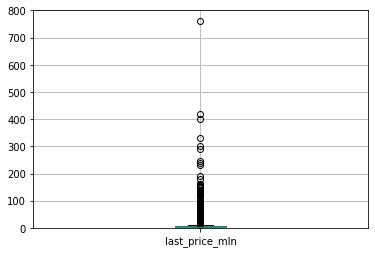

In [42]:
plt.ylim(0, 800)
df.boxplot('last_price_mln')
df['last_price_mln'].describe()

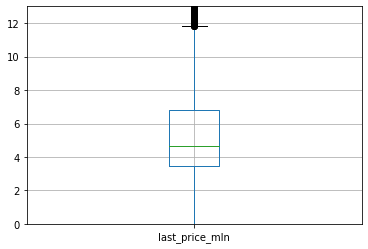

In [43]:
plt.ylim(0, 13)
df.boxplot('last_price_mln')

На диаграмме размаха видно, что медиана находится в районе 5млн, но за границей верхнего уса существует много значений, достигающих максимума в 763 млн. В то же время, нижняя граница значений сильно ниже 1млн. Это странно. Проверим, много ли таких в наших данных. 

In [44]:
len(df.query('last_price_mln < 1')) / len(df)

0.009453332192659765

In [45]:
df = df.query('last_price_mln >= 1')
df['last_price_mln'].describe()

count    23157.000000
mean         6.628315
std         10.985330
min          1.000000
25%          3.500000
50%          4.700000
75%          6.800000
max        763.000000
Name: last_price_mln, dtype: float64

Таких значений оказалось меньше 1%. Значит такая цена нехарактерна для недвижимости в регионе и является выбросом. Данные можно удалить. Медиана отличается от среднего, вероятно, из-за сверхвысоких значений цены. Q3 = 6.8млн, а мах - 763млн. Что это за суперэлитные объекты?

In [46]:
df.query('last_price_mln > 12')['last_price_mln'].describe()

count    1926.000000
mean       25.228609
std        31.917032
min        12.036000
25%        13.900000
50%        17.000000
75%        25.000000
max       763.000000
Name: last_price_mln, dtype: float64

In [47]:
df.query('last_price_mln > 25')['last_price_mln'].describe()

count    463.000000
mean      53.509006
std       56.124906
min       25.023000
25%       29.000000
50%       36.750000
75%       55.400000
max      763.000000
Name: last_price_mln, dtype: float64

In [48]:
df.query('last_price_mln < 12')['last_price_mln'].describe()

count    21174.000000
mean         4.921961
std          2.213938
min          1.000000
25%          3.400000
50%          4.490000
75%          6.000000
max         11.999000
Name: last_price_mln, dtype: float64

Оказалось, что объектов, стоимостью более 25 млн всего ок 2%. Значения на максимуме могут влиять на расчет среднего, но почти не влияют на медиану (она колеблется от 4.49 до 4.7 в разных выборках). Удалять эти данные не стоит - это могут быть крупные клиенты. 

Теперь разберемся с количеством комнат.

In [49]:
df['rooms'].describe()

count    23157.000000
mean         2.085244
std          1.077249
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

In [50]:
len(df.query('rooms == 0'))

135

In [51]:
len(df.query('rooms == 0 and studio == True'))

90

In [52]:
len(df.query('rooms == 0 and open_plan == True'))

45

Часть из них студии, а часть - с окрытой планировкой. Оставим. 

In [53]:
len(df.query('rooms > 3')) / len(df)

0.0729800924126614

В датасете есть объекты с большой площадью, так что 7% объектов с 4 и более комнатами - нормально. Осталось разобраться с потолками.

In [54]:
df['ceiling_height'].describe()

count    23157.000000
mean         2.736782
std          1.005366
min          1.000000
25%          2.550000
50%          2.650000
75%          2.750000
max        100.000000
Name: ceiling_height, dtype: float64

In [55]:
df.query('ceiling_height < 2.5').sort_values(by = 'ceiling_height', ascending=False)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,sq_m_price,weekday_exp,month_exp,year_exp,floor_name,living_part,kitchen_part,last_price_mln
21521,13,6800000,49.00,2018-03-21 03:00:00,2,2.49,8.0,32.8,2,True,...,136.0,21.0,138775.510204,2,3,2018,другой,0.669388,0.132653,6.800
3703,14,4000000,36.44,2018-04-15 03:00:00,1,2.48,9.0,19.8,2,True,...,NaN,194.0,109769.484083,6,4,2018,другой,0.543359,0.153677,4.000
17408,7,2730000,31.00,2018-02-12 03:00:00,1,2.48,5.0,17.0,1,True,...,878.0,169.0,88064.516129,0,2,2018,первый,0.548387,0.193548,2.730
10100,5,3450000,42.90,2017-10-27 03:00:00,2,2.48,5.0,26.8,5,True,...,878.0,154.0,80419.580420,4,10,2017,последний,0.624709,0.135198,3.450
9192,17,3690000,30.70,2019-02-07 03:00:00,1,2.48,5.0,17.2,5,True,...,523.0,NaN,120195.439739,3,2,2019,последний,0.560261,0.169381,3.690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11352,4,3300000,36.00,2017-06-18 03:00:00,1,2.00,17.0,15.2,12,True,...,NaN,53.0,91666.666667,6,6,2017,другой,0.422222,0.280556,3.300
552,11,2999000,33.50,2017-03-30 03:00:00,1,2.00,15.0,17.5,6,True,...,949.0,270.0,89522.388060,3,3,2017,другой,0.522388,0.194030,2.999
16934,5,4100000,40.00,2017-10-17 03:00:00,1,1.75,37.0,17.4,5,True,...,80.0,71.0,102500.000000,1,10,2017,другой,0.435000,0.208500,4.100
5712,5,1500000,42.80,2017-08-14 03:00:00,2,1.20,2.0,27.5,1,True,...,NaN,248.0,35046.728972,0,8,2017,первый,0.642523,0.121495,1.500


In [56]:
len(df.query('ceiling_height < 2.5')) / len(df)

0.003109211037699184

In [57]:
len(df.query('ceiling_height > 6')) / len(df)

0.0012955045990413266

In [58]:
df = df.query('2.5 <= ceiling_height < 6')
df['ceiling_height'].describe()

count    23054.000000
mean         2.709151
std          0.234040
min          2.500000
25%          2.550000
50%          2.650000
75%          2.750000
max          5.800000
Name: ceiling_height, dtype: float64

0,3% потолков ниже 2.5м и 0.1% потолков выше 6 м можно безболезненно удалить - это выбросы или ошибочно введенные данные. 

### *Какие факторы больше всего влияют на стоимость квартиры?*

In [59]:
price_depends = df[['sq_m_price', 'rooms', 'cityCenters_nearest']]

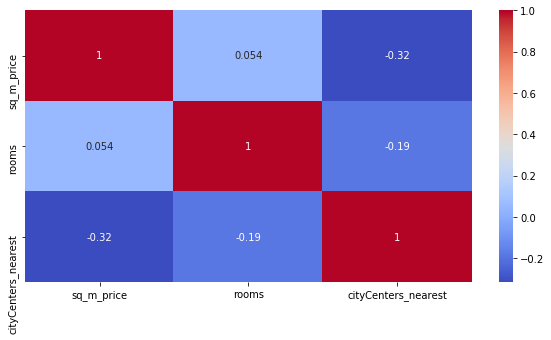

In [60]:
plt.rcParams['figure.figsize'] = (10.0, 5.0)
sns.heatmap(price_depends.corr(), annot=True, fmt='.2g', cmap= 'coolwarm');

Расчет коэффициента Пирсона показал, что стоимость объекта прямо коррелирует величиной (стоимостью) кв.метра. Это было ожидаемо.
Число комнат также прямо коррелирует с ценой, но не так сильно, как можно было предполагать. Метраж влияет на стоимость почти в 2 раза сильнее. 
Заметна существенная обратная корреляция стоимости недвижимости в зависимости от удаленности от центра. Чем меньше расстояние, тем больше цена. 

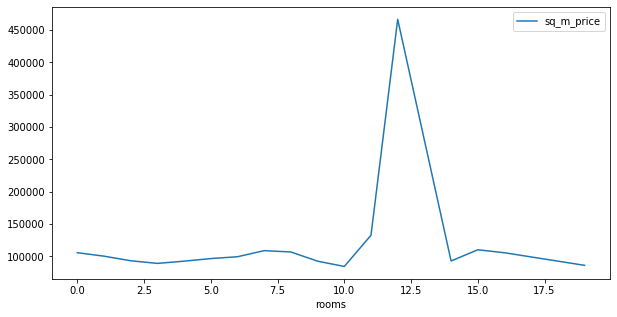

In [61]:
room_data = df.pivot_table(index='rooms', values='sq_m_price', aggfunc='median').plot();

У квартир с количеством комнат в диапазоне от 10 до 14 необъяснимо резко взлетает цена за кв.м. 

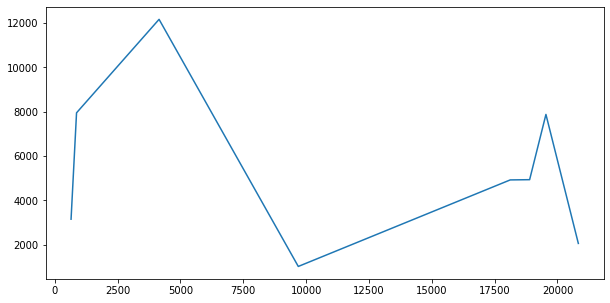

In [62]:
df.query('10 <= rooms < 15')['cityCenters_nearest'].plot();

In [63]:
df.query('10 <= rooms < 15')['cityCenters_nearest'].describe()

count        8.00000
mean      5508.25000
std       3670.49151
min       1015.00000
25%       2874.50000
50%       4926.50000
75%       7895.25000
max      12169.00000
Name: cityCenters_nearest, dtype: float64

Вероятнее всего, это связано с расположением в престижных локациях в центре и за городом. Таких объектов всего 8, мб это суперэлитка. 

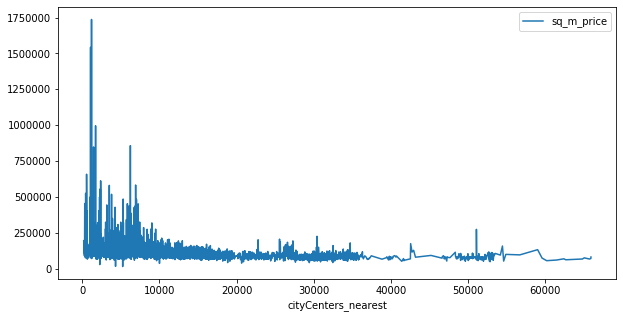

In [64]:
from_center_data = df.pivot_table(index='cityCenters_nearest', values='sq_m_price', aggfunc='median').plot()

По графику видно, что самые дорогие объекты расположены на расстоянии 8000 от городского центра. 

#### Зависимость цены от этажа(первый, последний, другой): 

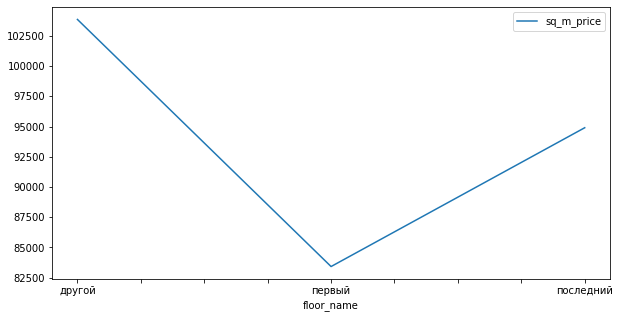

In [65]:
floor_data = df.pivot_table(index='floor_name', values='sq_m_price').plot()

Дешевле всего квартиры на первом этаже, потом на последнем. Самые дорогая недвижимость - на средних этажах домов. 

#### Зависимость от даты размещения (дня недели, месяца и года):

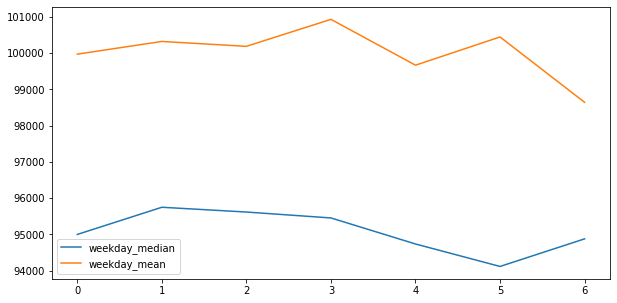

In [66]:
weekday_median = df.pivot_table(index='weekday_exp', values='sq_m_price', aggfunc='median')
weekday_mean = df.pivot_table(index='weekday_exp', values='sq_m_price')
plt.plot(weekday_median, label='weekday_median')
plt.plot(weekday_mean, label='weekday_mean') 
plt.legend()
plt.show()

Любопытно, что графики зависимости цены от времени публикаций, рассчитанные по медиане и по среднему - разные. 
Синяя линия - график размещения основой части объявлений. Судя по нему, максимальную цену на недвижимость среднего класса указывают во вт, с чт по сб происходит резкое падение, с в вс и пн - постепенный рост. 
На оранжевом графике видно, что самые дорогие объекты размещают в чт и сб! А в вс происходит максимальное падение цены.  

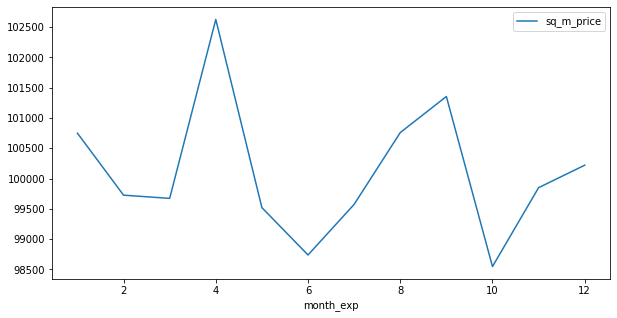

In [67]:
month_data = df.pivot_table(index='month_exp', values='sq_m_price').plot()

Самую дорогую недвижимость продают в апреле, затем в сентябре. В октябре и июне самые сильные падения цены. Получается, что рынок подвержен характерным сезонным колебаниям.  

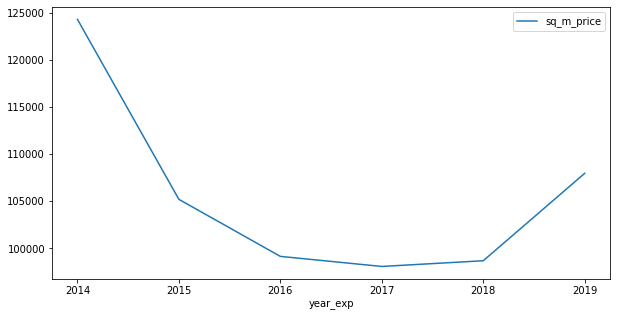

In [68]:
year_data = df.pivot_table(index='year_exp', values='sq_m_price').plot()

С 2014 до 2017 г наблюдается устойчивое снижение цены. К 2018 г цена за м2 немного выросла, с 2018г происходит заметный рост. 

### *10 населённых пунктов с наибольшим числом объявлений:*

In [69]:
df['locality_name'].value_counts().head(10)

Санкт-Петербург      15513
посёлок Мурино         489
посёлок Шушары         434
Всеволожск             392
Пушкин                 365
Колпино                336
посёлок Парголово      325
Гатчина                305
деревня Кудрово        286
Выборг                 229
Name: locality_name, dtype: int64

In [70]:
top_10_locality_names = df['locality_name'].value_counts().head(10).index.values
top_10_locality_names

array(['Санкт-Петербург', 'посёлок Мурино', 'посёлок Шушары',
       'Всеволожск', 'Пушкин', 'Колпино', 'посёлок Парголово', 'Гатчина',
       'деревня Кудрово', 'Выборг'], dtype=object)

In [71]:
top_10_locality = df.query('locality_name in @top_10_locality_names')
top_10_df = top_10_locality.pivot_table(index='locality_name', values='sq_m_price', aggfunc='mean'
                           ).reset_index().sort_values(by = 'sq_m_price', ascending=False)
top_10_df

,locality_name,sq_m_price
5,Санкт-Петербург,114766.531563
4,Пушкин,103102.846340
6,деревня Кудрово,92116.747438
8,посёлок Парголово,90303.491729
7,посёлок Мурино,84985.286281
9,посёлок Шушары,78181.912186
3,Колпино,75350.597216
2,Гатчина,68947.384358
0,Всеволожск,68759.924685
1,Выборг,58517.670737


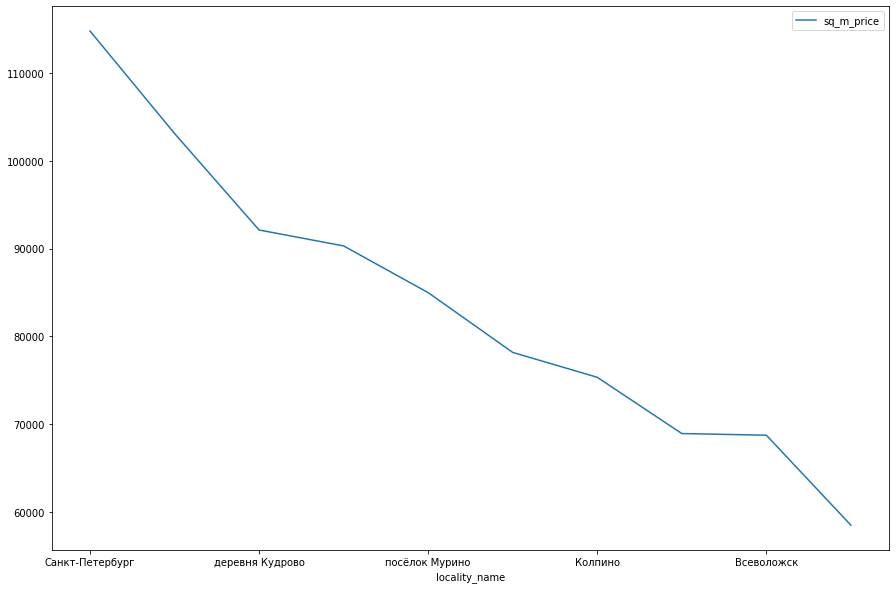

In [72]:
plt.rcParams['figure.figsize'] = (15.0, 10.0)
top_10_locality.pivot_table(index='locality_name', values='sq_m_price', aggfunc='mean'
                           ).sort_values(by = 'sq_m_price', ascending=False).plot();

Из 10-ки городов с самым большим количеством объявлений, в Санкт-Петербурге квартиры самые дорогие, а в Выборге - самые дешевые. 

### *Анализ стоимости квартир в центральной зоне Санкт-Петербурга:*

Определим границы центральной зоны по стоимости:

In [73]:
spb_data = df.query('locality_name == "Санкт-Петербург"')
spb_data['from_center'] = spb_data['cityCenters_nearest'] / 1000
spb_data['from_center'] = spb_data['from_center'].astype('int')
spb_data['from_center'].describe()

C:\Users\USER\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\USER\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


count    15513.000000
mean        11.099336
std          4.822587
min          0.000000
25%          8.000000
50%         12.000000
75%         14.000000
max         29.000000
Name: from_center, dtype: float64

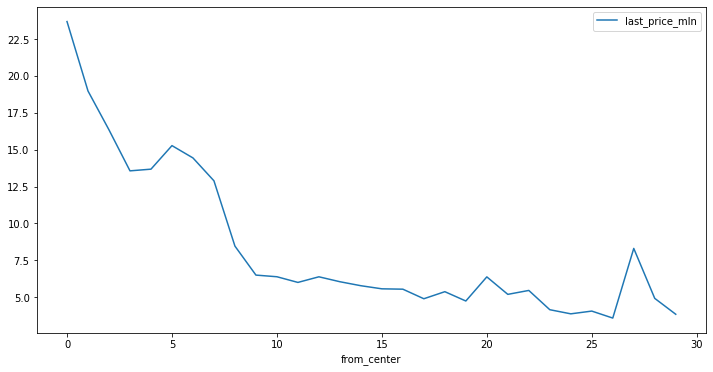

In [74]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
spb_data.pivot_table(index='from_center', values='last_price_mln', aggfunc='mean').plot();

Судя по графику, центральная зона Санкт-Петербурга ограничивается 5 км. 

Изучим квартиры в центральной зоне:

In [75]:
spb_center_data = spb_data.query('from_center <= 5')

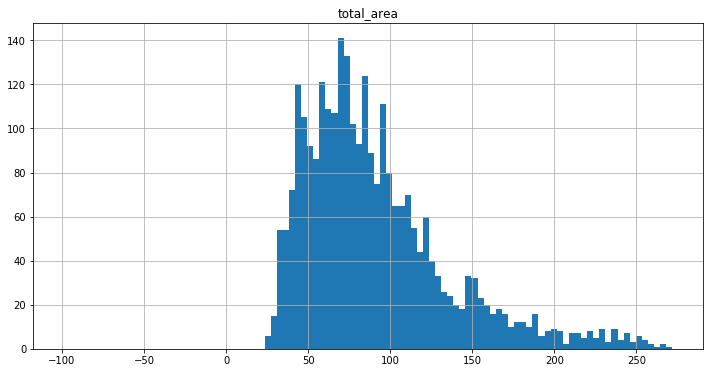

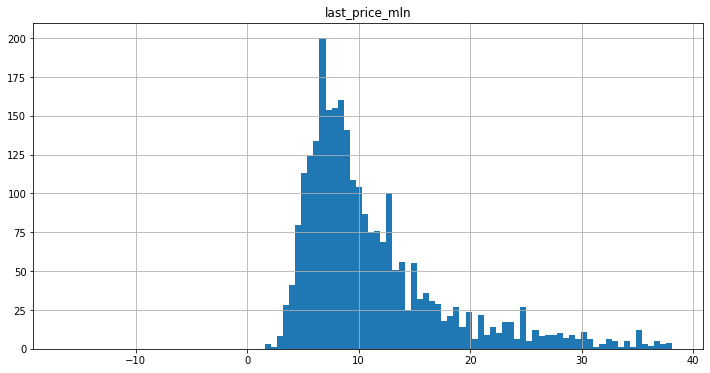

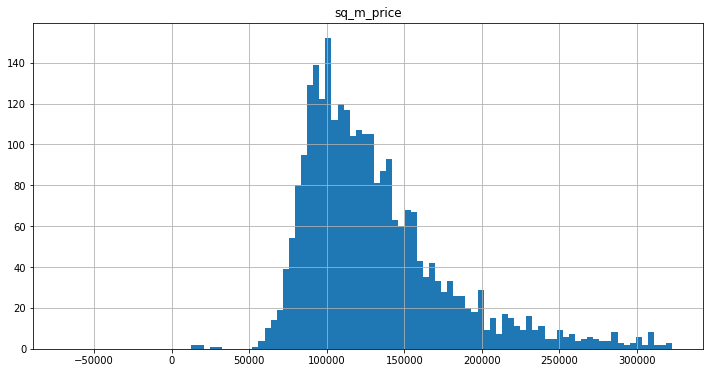

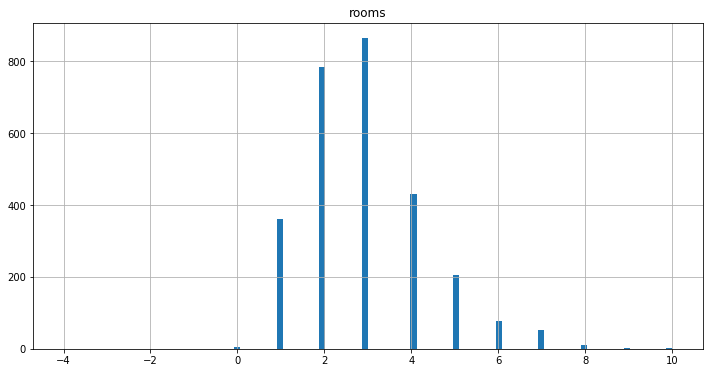

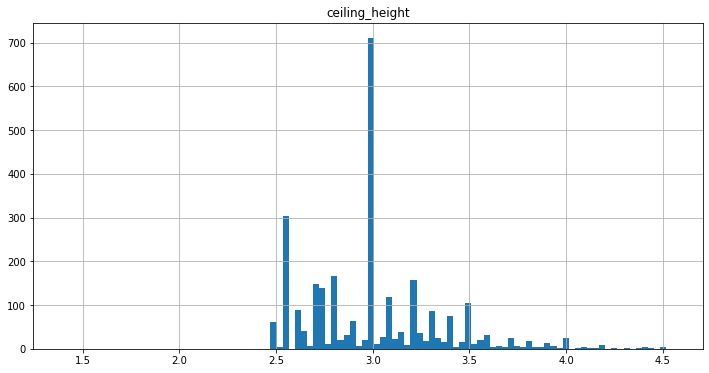

In [76]:
spb_center_hist_data = spb_center_data[['total_area', 'last_price_mln', 'sq_m_price', 'rooms', 'ceiling_height']]

for row in spb_center_hist_data:
    Q1 = spb_center_hist_data[row].describe()['25%']
    Q3 = spb_center_hist_data[row].describe()['75%'] 
    spb_center_hist_data[row].hist(bins=100, range=(Q1-3*(Q3-Q1), Q3+3*(Q3-Q1)))
    plt.title(row)
    plt.show()

In [77]:
spb_center_hist_data.describe()

,total_area,last_price_mln,sq_m_price,rooms,ceiling_height
count,2798.000000,2798.000000,2.798000e+03,2798.000000,2798.000000
mean,96.621308,15.133160,1.433613e+05,2.966047,3.010239
std,60.628657,25.540235,9.566378e+04,1.500539,0.364708
min,25.000000,1.600000,1.534527e+04,0.000000,2.500000
25%,60.000000,6.950000,9.849920e+04,2.000000,2.750000
50%,82.000000,9.500000,1.215746e+05,3.000000,3.000000
75%,113.000000,14.750000,1.545784e+05,4.000000,3.200000
max,631.200000,763.000000,1.907500e+06,19.000000,5.800000


В объявлениях из центральной части Санкт-Петербурга больше всего объектов площадью 75 кв.м. Но вообще одинаково много квартир от 40 до 100 кв.м. Большая часть недвижимости стоит мене 10 млн. Есть пик в районе 7млн., возможно это связано со стандартной площадью объекта. Наибольшее количество комнат - 3, стандартная высота потолка - 3м. 

На графике с ценой за кв.м видны выбросы значений менее 50000 за кв.м. Это выглядит подозрительно: в основном цена колеблестся от 75000 до 125000. 

In [78]:
spb_center_data.query('sq_m_price < 50000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,sq_m_price,weekday_exp,month_exp,year_exp,floor_name,living_part,kitchen_part,last_price_mln,from_center
7756,1,4390000,151.8,2017-04-28 03:00:00,6,3.5,6.0,106.5,6,False,...,44.0,28919.631094,4,4,2017,последний,0.701581,0.094203,4.39,2
13739,19,2100000,80.0,2016-07-01 03:00:00,4,3.0,6.0,23.0,3,True,...,23.0,26250.000000,4,7,2016,другой,0.287500,0.175000,2.10,5
17753,12,1800000,117.3,2016-02-18 03:00:00,5,3.0,4.0,23.6,2,False,...,139.0,15345.268542,3,2,2016,другой,0.201194,0.109974,1.80,5
19952,7,2200000,138.7,2016-06-24 03:00:00,4,3.0,7.0,90.7,5,False,...,203.0,15861.571738,4,6,2016,другой,0.653929,0.098774,2.20,4
21338,15,3200000,190.0,2016-06-16 03:00:00,1,3.0,6.0,43.0,4,False,...,11.0,16842.105263,3,6,2016,другой,0.226316,0.068421,3.20,4
23394,10,1600000,92.0,2018-07-10 03:00:00,3,3.0,6.0,13.0,1,True,...,3.0,17391.304348,1,7,2018,первый,0.141304,0.108696,1.60,4


In [79]:
spb_center_data = spb_center_data.query('sq_m_price >= 50000')

Это явно выброс или недостоверные данные. Я решила их удалить. 

Изучим факторы, влияющие на стоимость квартир:

In [80]:
spb_center_data.corr()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,...,ponds_nearest,days_exposition,sq_m_price,weekday_exp,month_exp,year_exp,living_part,kitchen_part,last_price_mln,from_center
total_images,1.000000,0.139686,0.099612,0.032226,0.094219,-0.051397,0.081104,-0.013866,0.084039,-0.014588,...,0.006080,-0.049001,0.168578,0.004619,-0.013859,0.164805,-0.008897,0.039832,0.139686,-0.023890
last_price,0.139686,1.000000,0.595119,0.295187,0.117318,0.046811,0.491430,0.124905,0.007468,-0.013541,...,-0.064332,0.050837,0.793972,0.034656,-0.010437,-0.031828,-0.050160,-0.107604,1.000000,-0.055372
total_area,0.099612,0.595119,1.000000,0.738642,0.249607,-0.013131,0.905674,0.115891,0.015095,-0.032654,...,-0.064238,0.130772,0.223024,0.013373,-0.022856,-0.060203,0.086055,-0.360213,0.595119,-0.052297
rooms,0.032226,0.295187,0.738642,1.000000,0.206219,-0.167397,0.821458,-0.028541,0.016811,-0.086575,...,-0.049196,0.117311,-0.026056,-0.003502,-0.027857,-0.042816,0.420466,-0.493089,0.295187,-0.107437
ceiling_height,0.094219,0.117318,0.249607,0.206219,1.000000,-0.255956,0.283267,-0.141391,-0.026790,0.045347,...,-0.064789,0.072130,0.054264,-0.021589,-0.021320,0.034966,0.140570,-0.109919,0.117318,-0.170905
floors_total,-0.051397,0.046811,-0.013131,-0.167397,-0.255956,1.000000,-0.130965,0.649316,-0.016456,0.015640,...,0.093482,0.035305,0.121269,0.012151,0.021134,-0.053052,-0.354849,0.159856,0.046811,0.317278
living_area,0.081104,0.491430,0.905674,0.821458,0.283267,-0.130965,1.000000,0.012014,0.011816,-0.022567,...,-0.051090,0.122918,0.136052,0.002805,-0.013735,-0.066748,0.421924,-0.459115,0.491430,-0.104346
floor,-0.013866,0.124905,0.115891,-0.028541,-0.141391,0.649316,0.012014,1.000000,-0.020531,-0.002583,...,0.049707,0.040584,0.131311,0.034744,0.031553,-0.051337,-0.234500,0.038312,0.124905,0.200543
is_apartment,0.084039,0.007468,0.015095,0.016811,-0.026790,-0.016456,0.011816,-0.020531,1.000000,-0.006548,...,0.027115,-0.076299,0.017641,0.013864,0.088036,0.226457,-0.005480,-0.000870,0.007468,-0.015238
studio,-0.014588,-0.013541,-0.032654,-0.086575,0.045347,0.015640,-0.022567,-0.002583,-0.006548,1.000000,...,0.032020,-0.023880,-0.000386,0.000810,0.003433,-0.006119,0.040863,0.029844,-0.013541,0.022782


Посмотрим, как различается средняя цена на квартиры в общем и в центральной зоне:

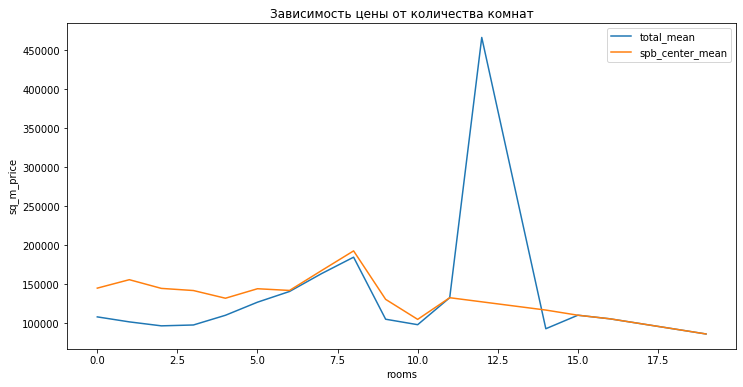

In [81]:
df_rooms = df.pivot_table(index='rooms', values='sq_m_price', aggfunc='mean')
spb_center_rooms = spb_center_data.pivot_table(index='rooms', values='sq_m_price', aggfunc='mean')

plt.plot(df_rooms, label='total_mean')
plt.plot(spb_center_rooms, label='spb_center_mean')
plt.title('Зависимость цены от количества комнат')
plt.xlabel('rooms')
plt.ylabel('sq_m_price')
plt.legend()
plt.show();

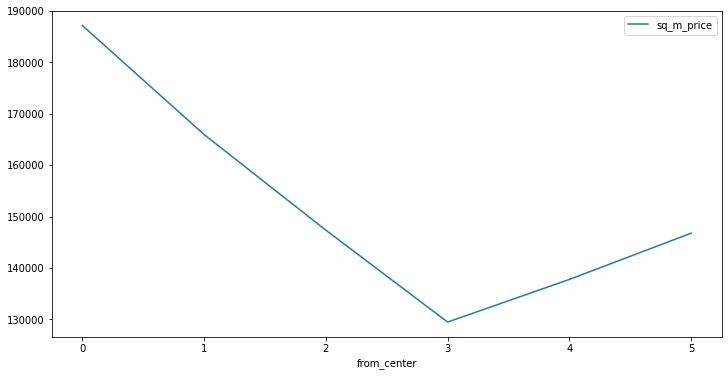

In [82]:
spb_center_data.pivot_table(index='from_center', values='sq_m_price', aggfunc='mean').plot();

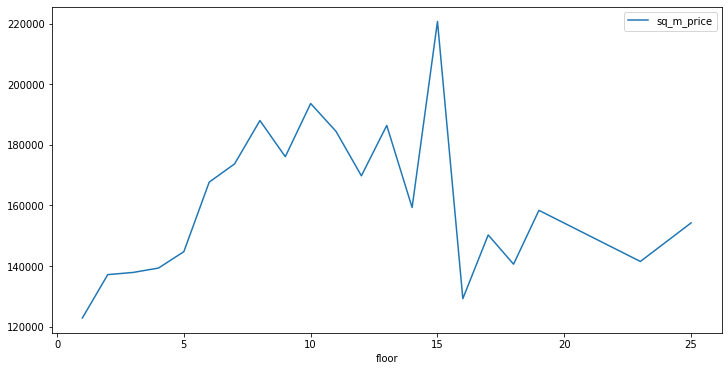

In [83]:
spb_center_data.pivot_table(index='floor', values='sq_m_price', aggfunc='mean').plot();

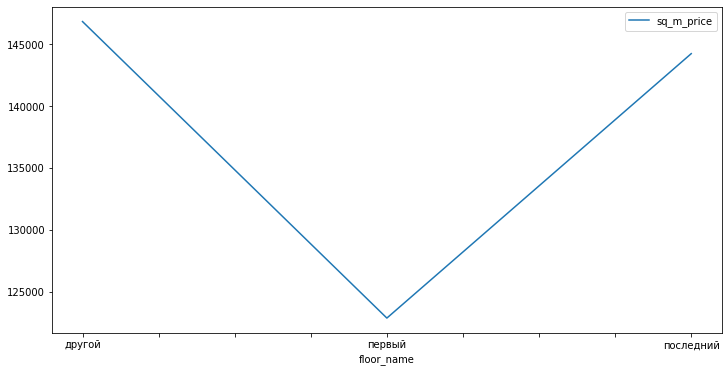

In [84]:
spb_center_data.pivot_table(index='floor_name', values='sq_m_price', aggfunc='mean').plot();

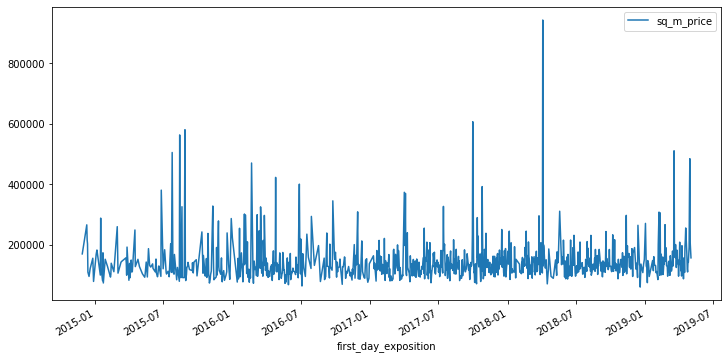

In [85]:
spb_center_data.pivot_table(index='first_day_exposition', values='sq_m_price', aggfunc='mean').plot();

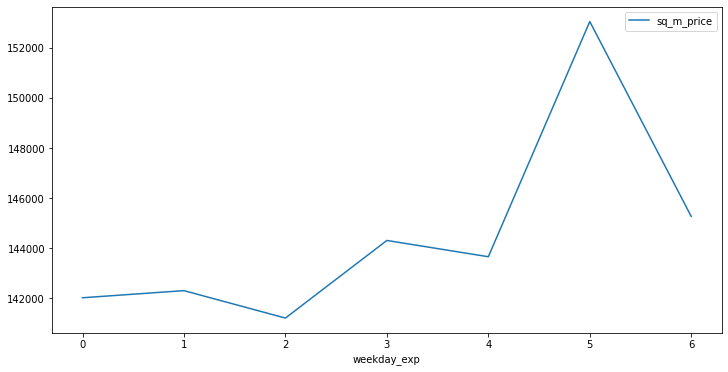

In [86]:
spb_center_data.pivot_table(index='weekday_exp', values='sq_m_price', aggfunc='mean').plot();

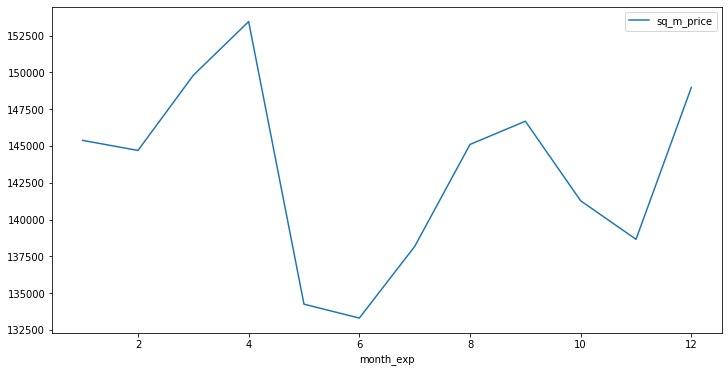

In [87]:
spb_center_data.pivot_table(index='month_exp', values='sq_m_price', aggfunc='mean').plot();

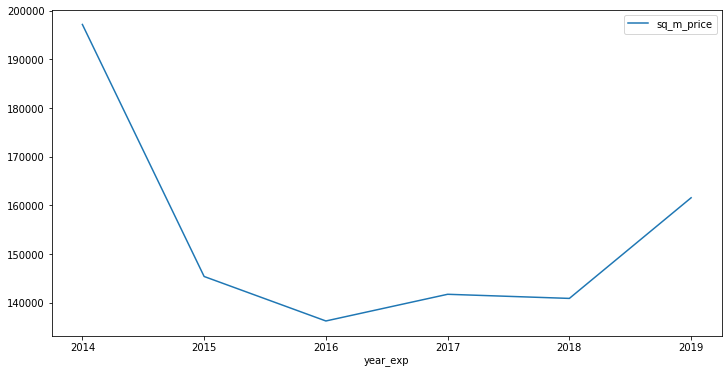

In [88]:
spb_center_data.pivot_table(index='year_exp', values='sq_m_price', aggfunc='mean').plot();

Судя по графикам, дороже всего квартиры с 8 комнатами и однушки. Это значительное отличие центальной части города. 
Любопытно, что в районе 3км от центра - самые дешевые квартиры. Скорее всего там не развита инфраструктура, расположена промзона или слишком много шумных туристов. Лучшая недвижимость центра - квартиры на 7-15 этажах. Пентхаусы в цене! В отличие от остальной части города - там последний этаж почти вдвое дешевле средних этажей. 
Графики взаимосвязи цена/время публикации тоже отличаются. Самые дорогие объявления публюкуются в сб, в апреле, декабре и сентябре. С 2014 г цена здесь тоже сильно упала. В целом, по годам сильных различий с остальным рынком недвижимости нет. 


<div id='step5'/>

### Шаг 5. Общий вывод

##### Для работы над проектом нужно было проанализировать архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов из сервиса Яндекс.Недвижимость за 2014-2019гг.
##### Задача: установить параметры для определения рыночной стоимости объектов недвижимости, которые можно будет использовать для разработки автоматизированной системы отслеживания аномалий и мошеннических действий.

Данные состоят из двух частей: введенные вручную и полученные автоматически на основе картографических данных.
В ходе предварительной обработки данных,  я обнаружила от 20% до 60% пропусков в части автоматически сгенерированных данных. Необходимо проверить работу алгоритма.  

Пропуски в данных, необходимых для работы над проектом, я заполнила соответствующими средними значениями. 
В качестве ключевых параметров я исследовала: цену, общую площадь, стоимость кв.м., количество комнат, высоту потолка, этаж (первый, последний, другой), время размещения объявления (день недели, месяц, год),  удаленность от центра (для центральной части Санкт-Петербурга). 

Я проанализировала данные и установила пороговые значения для некоторых параметров:
Min цена для квартиры – 1 млн руб;
Min общая площадь – 25м2;
Min стоимость кв.м. в центральной части Санкт-Петербурга – 50 000 руб;
Min высота потолка – 2.5м;
Max высота потолка – 6м;
Центральная часть Санкт-Петербурга ограничена расстоянием в 5 км.

##### Общие выводы по анализу объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах:

Больше всего объектов находится в Санкт-Петербурге, поселке Мурино, поселке Шушары, Всеволожске, Пушкине, Колпино, посёлке Парголово, Гатчине, деревне Кудрово и Выборге. 
В Санкт-Петербурге самая дорогая недвижимость по цене за кв.м, в Выборге – самая дешевая. Стоимость объекта  варьируется от 1 млн руб. до 763 млн руб. Медина - 3-5 млн. 
Разброс площади объектов 25 кв.м. до 900 кв.м. Большинство из них находится в диапазе25 - 50 кв.м.
Количество комнат варьируется от 0 (для студий) до 19. В основном – это 1 и 2-х, чуть реже 3-х комнатные квартиры. 
Высота потолков в среднем составляет 2.5 – 3 м, но бывает и выше – до 6 м. Я выявила незначительную корреляцию высоты потолка и общей площади. 
Существует зависимость цены квартиры от этажа, на котором она расположена. Дешевле всего квартиры на первом этаже, потом на последнем. Самая дорогая недвижимость расположена на других этажах. 
Время публикации объявления коррелирует со стоимостью объекта. 
Самые дорогие квартиры появляются по вторникам, в апреле и сентябре. С 2014 до 2017 г наблюдалось устойчивое снижение цены. В 2017 - 2018 гг цена начала немного расти, с 2018 г виден заметный рост.
Большинство объявлений снимаются в течение года после размещения, но есть и долгожители.  Среднее время продажи по медиане - 3 месяца, общее среднее – полгода. Быстрые сделки закрываются за неделю или 30 дней. 

Aнализ продолжительности продажи выявил аномальные значения. 8% объявлений были сняты в промежутке 45-60 дней. Эти данные коррелируют с нехарактерными  пиками удаления объявлений в дек-янв 2017/2018 гг. Возможно произошел сбой системы, необходимо проинформировать специалистов. 

Корреляция:
Расчет коэффициента Пирсона показал, что стоимость объекта прямо коррелирует с площадью, количеством комнат. Заметна существенная обратная корреляция цены квартиры в зависимости от удаленности от центра. Чем меньше расстояние, тем дороже.

##### Анализ центральной зоны Санкт-Петербурга:

Я выделила объекты, расположенные в пределах 5 км от центра Санкт-Петербурга и проанализировала их отдельно. 
Стоимость объекта  варьируется от 1,6 млн руб. до 763 млн руб. Медина – 9,5 млн руб. Большая часть недвижимости стоит мене 10 млн руб. 
Разброс площади объектов 25 кв.м. до 631 кв.м. Большинство из них находится в диапазоне 40 - 100 кв.м. Медиана – 82 кв.м
Количество комнат варьируется от 0 (для студий) до 19. В основном – это 3-х и 2-х комнатные квартиры. 
Стандартная высота потолка – 3 м.
Зависимость цены квартиры от этажа, на котором она расположена, немного иная. Также дешевле всего квартиры на первом этаже, но последний ценится в среднем так же, как и остальные. 
Заметны колебания в цене в зависимости от удаленности от центра. Есть провал на отметке 3 км, до и после которого цена значительно выше. 
Время публикации объявления коррелирует со стоимостью объекта. 
Самые дорогие квартиры появляются в субботу, в апреле, декабре и сентябре. С 2014 до 2017 г наблюдалось устойчивое снижение цены. В 2017 - 2018 гг цена начала немного расти, с 2018 г виден заметный рост.

Можно сказать, что для рынка квартир в центральной части Санкт-Петербурга есть свои характерные особенности. Здесь в среднем выше стоимость кв.м., больше площадь, количество комнат и высота потолка в квартирах. Любопытно, что на среднюю стоимость почти не влияет расположение на последнем этаже дома. Время размещения объявления также коррелирует с ценой, но тренды другие.  

##### В качестве критериев для определения рыночной стоимости объектов недвижимости я предлагаю использовать следующие параметры: 

- Общая площадь: минимум и медиана;
- Стоимость кв.м. минимум (свой для центра Санкт-Петербурга) и медиана;
- Высота потолка 2.5 - 6 м;
- Этаж (первый, последний, другой);
- Время размещения объявления (день недели, месяц, год);
- Удаленность от центра (для центральной части Санкт-Петербурга). 

Я анализировала высокие значения стоимости по разным параметрам и не считаю целесообразным вводить ограничения по max. Таких объектов немого и на них есть свой спрос. 

